<a href="https://colab.research.google.com/github/brenoskuk/image_processing_exercises/blob/master/PCA_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze toy examples, recognize faces and segment skin lesion images.

You have two weeks (8/04) to update a small report (2 jupyter notebooks + theoretical questions) to the *site pédagogique* of IMA205 under the section *Reports-TP*. You can answer in French or English. The deadline is 23:59 of the 8th of April. I remind you that the report is mandatory and evaluated. 

**All reports uploaded after the deadline will not be evaluated, namely grade equal to 0**

In this jupyter notebook, you can play with the toy examples shown during the lecture. 

First let's load the functions we will use

In [ ]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group

The next three functions are used to create the data and plot the results. Analyse them and try to understand what they do.

In [ ]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    elif scenario == 5:
        # Uncentered Gaussian
        mean0 = [3, 7]
        mean1 = [-5, 2]
        cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    return X0,X1,y

def plotResults(X=None,U=None,Y=None,const=1,title=''):
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios.

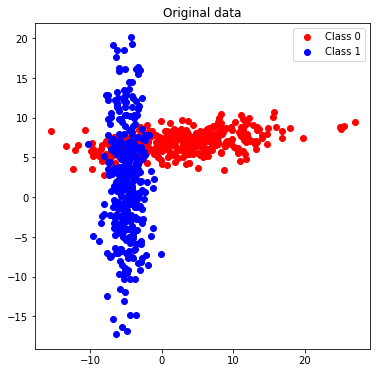

In [ ]:
X0,X1,y = generate_scenario(scenario=5, n_samples0 = 350, n_samples1 = 350)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

It's time to use the methods seen this morning. 

As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 

Let's start with PCA. 

**Question:** Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? How can you undesrtand when it 'works well' ? What does it mean in your opinion?

**Answer:** 
It works well on distribution 1, wich follows the assuptions of PCA:



1.   Linearity: linear transformation of the data
2.   Normality: data are assumed to follow a Gaussian distribution (mean
and variance are assumed to be sufficient statistics)
3. Large variance means interesting: directions with largest variance are
assumed to be the ones with most interest
4. Not scale invariant: it depends on the scaling of the features






Distribution 4 is not linear and thus PCA wont't work at all.
It also assumes that the directions where the variance is greatest are the most interesting while also imposing orthonormality. This proves not to be a good representetion of distribution 3 since variance doesn't seem to be maximized in any of the components. With overlapping sources, wich is the case of distribution 2, it works to some extent, but maybe another method proves more interesting. 

[0.6822832 0.3177168]


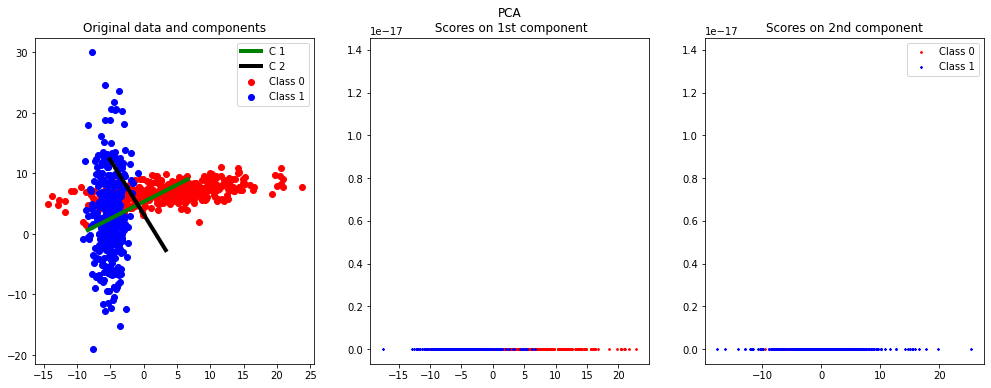

In [ ]:
X0,X1,y = generate_scenario(scenario=5, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

Xc = X - np.mean(X, axis = 0)
## PCA
pca = PCA(random_state=1)
Ypca=pca.fit_transform(Xc)
U=pca.components_.T # we want PC on columns
print(pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')

[0.96803695 0.03196305]


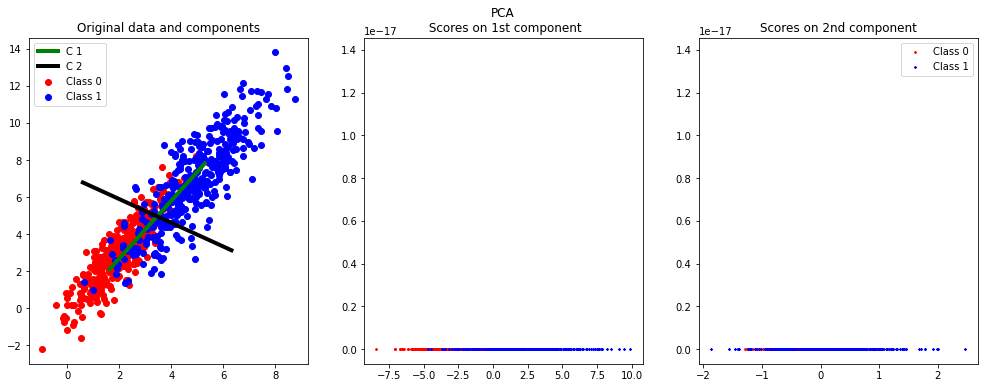

In [ ]:
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

pca = PCA(random_state=1)
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
print(pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')


[0.54445244 0.45554756]


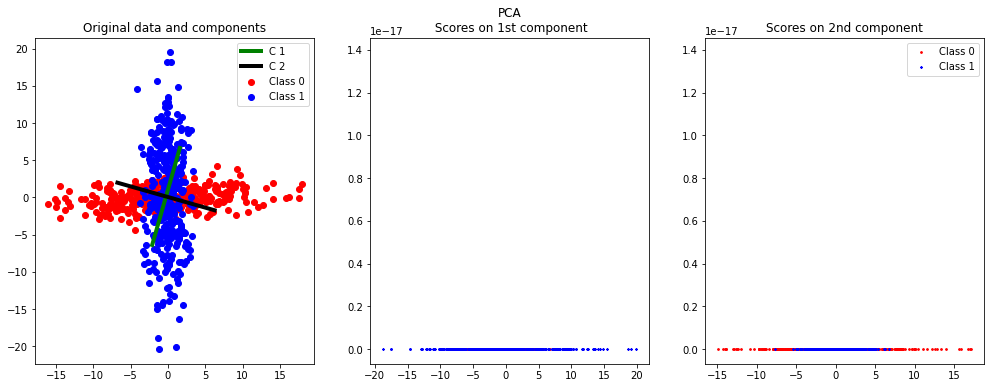

In [ ]:
X0,X1,y = generate_scenario(scenario=3, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

pca = PCA(random_state=1)
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
print(pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')


[0.50142558 0.49857442]


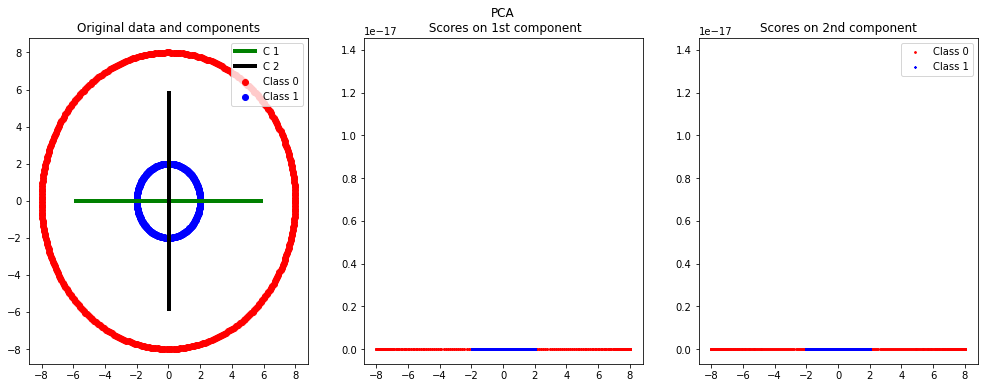

In [ ]:
X0,X1,y = generate_scenario(scenario=4, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

pca = PCA(random_state=1)
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
print(pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')


Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    d=X.shape[1]
    Xc= X - np.mean(X) # centering
    D2, Uh = LA.svd(Xc)[1:3] # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    #print('D2 =\n ', D2)
    #print('U =\n ', U, '\n|U0|=\n',np.dot(U[0],U[0]))
    Y=np.array([[np.dot(X[i],U[j]) for j in range(d)] for i in range(N)]) # computation of the scores
    #print('Y shape =\n ', Y.shape)
    D=D2**2/(N-1) # computation of the eigenvalues

    var_explained = D/np.sum(D)

    return Y,U,D,var_explained

Test your own implementation

[0.94515244 0.05484756]


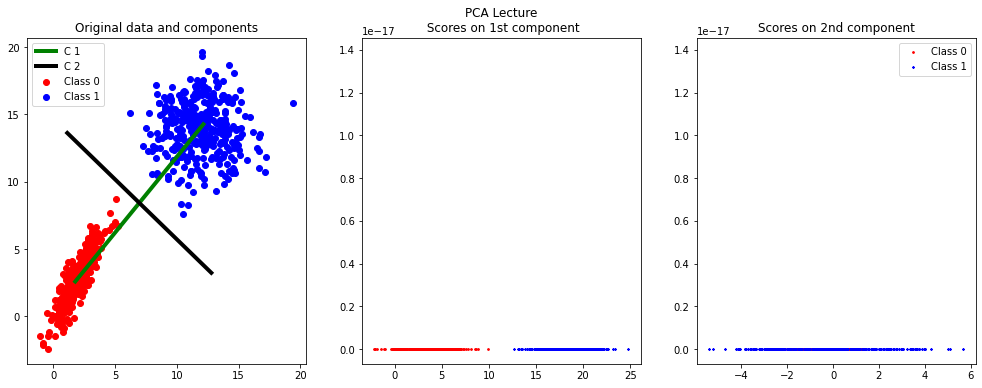

In [ ]:
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
print(var_explainedPcaLec)
plotResults(X,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


Let's use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:** Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?


**Answer:** The method works better on the scenario 4, where we have a non linear and symetric distribution (wich means we can apply the kernel trick). The only problem is finding the best parameter 'gamma'. We could use a grid search to achieve this, but fortunately we were able to found that gamma = 0.1 separates well the data.

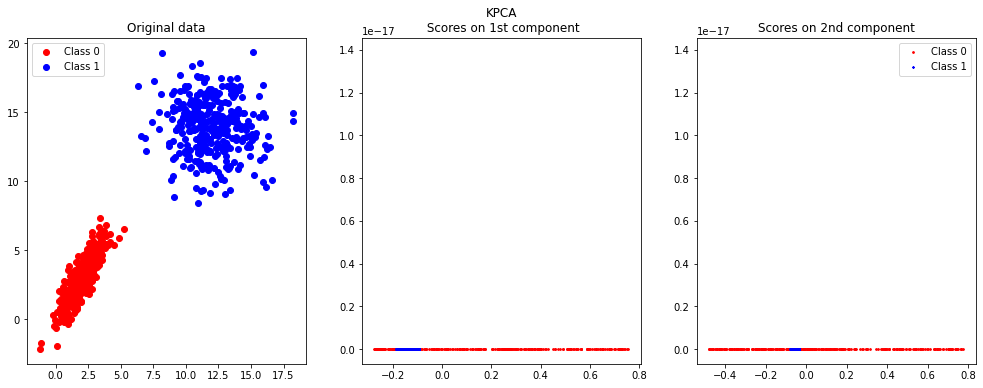

In [ ]:
# Kernel-PCA
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)


gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X=X,Y=YKpca,const=1,title='KPCA')

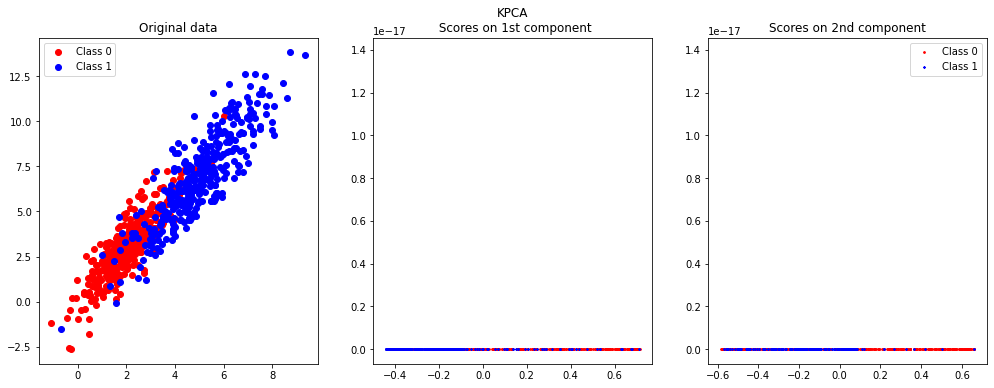

In [ ]:
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

gamma=1
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X=X,Y=YKpca,const=1,title='KPCA')

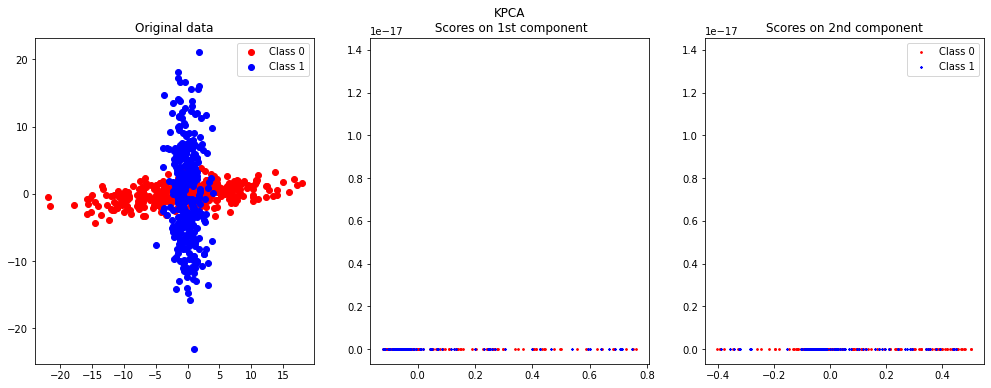

In [ ]:
X0,X1,y = generate_scenario(scenario=3, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X=X,Y=YKpca,const=1,title='KPCA')

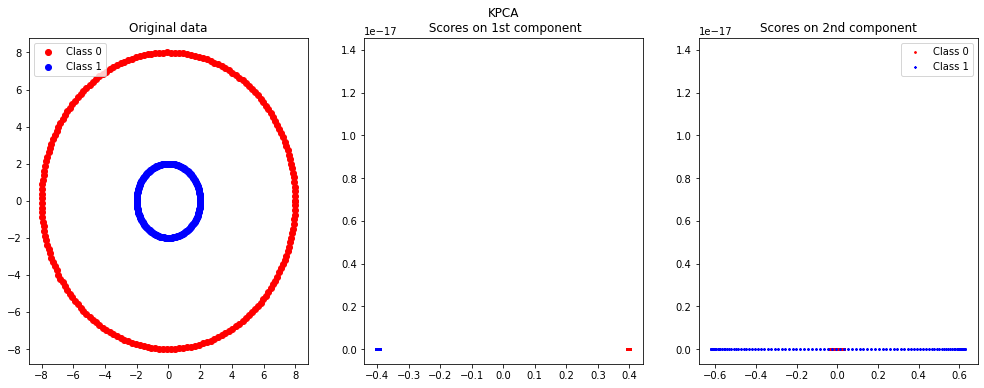

In [ ]:
X0,X1,y = generate_scenario(scenario=4, n_samples0 = 200, n_samples1 = 200)
X=np.concatenate((X0,X1),axis=0)

gamma=0.1
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_

plotResults(X=X,Y=YKpca,const=1,title='KPCA')

Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

    '''
       
    N=X.shape[0]

    # Computation of the Kernel matrix K [N,N]
    # Use a rbf kernel
    dists = np.zeros([N,N])
    for i in range(N):
      for j in range(N):
        dists[i][j] = np.dot(X[i] - X[j],X[i] - X[j])  
    K = np.exp(-gamma*dists)
    
    # center kernel matrix
    ones_N = np.ones((N,N))*(1/N)
    Kc = K - ones_N.dot(K) - K.dot(ones_N) + ones_N.dot(K.dot(ones_N))   

    # eigenvalue analysis
    D,A=LA.eigh(Kc);     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=An[:,i]/D[i]          
           
    Y=np.column_stack([An[:, i] for i in range(N)])    # computation of the scores  
    
    return Y, D

Test your own implementation

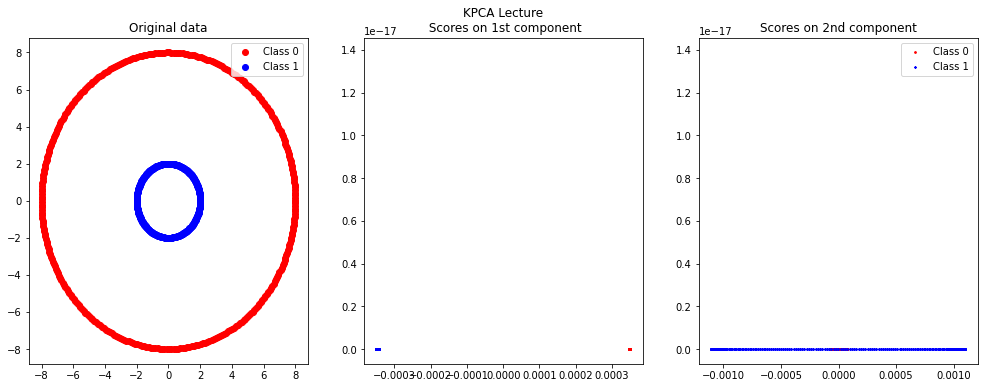

In [ ]:
X0,X1,y = generate_scenario(scenario=4, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

gamma = 0.1

YKpcaLec, DKpcaLec = KpcaGaussianLecture(X,gamma)
plotResults(X=X,Y=YKpcaLec,const=1,title='KPCA Lecture')

Now, test ICA.

**Question:** Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

**Answer:** It works well on the same data as PCA, however as it is a Higher-order method, not only covariance matrix data are not assumed to follow a Gaussian distribution but it yields a new basis which is not necessarily
orthogonal, proving to be more general than PCA.
We see that it differentiantes better data in scenario 2 and 3. It's still not perfect on areas where there is a lot of superposition.

ICA doesn't work for distribution 4.

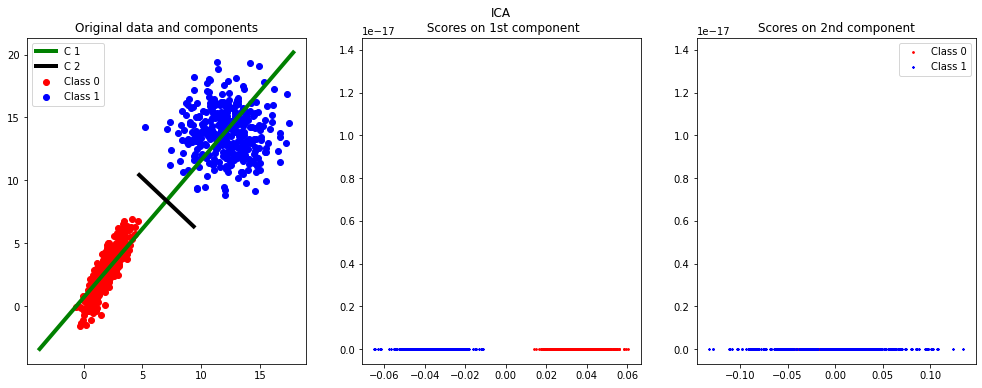

In [ ]:
## ICA
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Aica=ICA.mixing_
plotResults(X=X,U=Aica,Y=Yica,const=0.01,title='ICA')

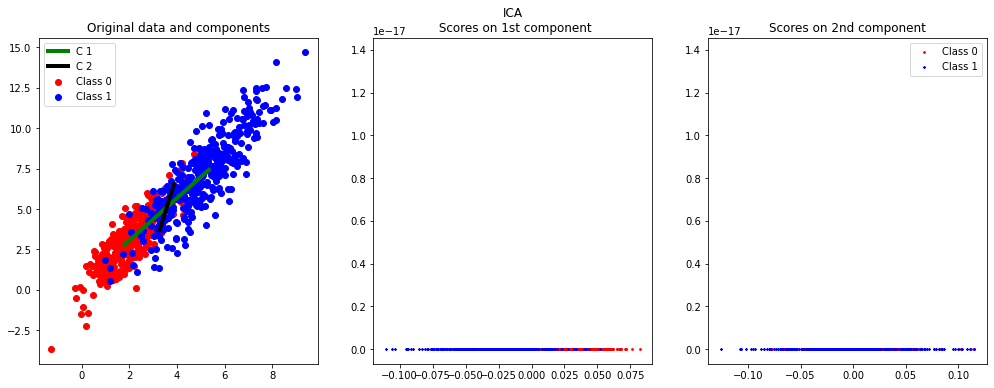

In [ ]:
## ICA
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Aica=ICA.mixing_
plotResults(X=X,U=Aica,Y=Yica,const=0.01,title='ICA')

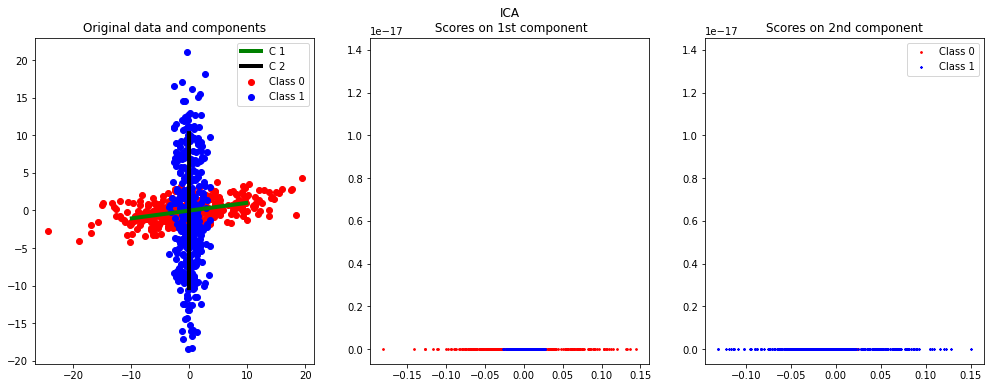

In [ ]:
## ICA
X0,X1,y = generate_scenario(scenario=3, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Aica=ICA.mixing_
plotResults(X=X,U=Aica,Y=Yica,const=0.01,title='ICA')

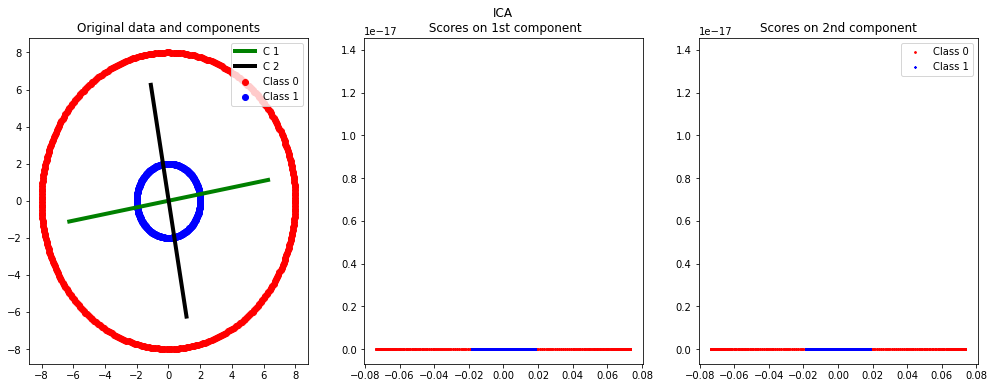

In [ ]:
## ICA
X0,X1,y = generate_scenario(scenario=4, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Aica=ICA.mixing_
plotResults(X=X,U=Aica,Y=Yica,const=0.01,title='ICA')

Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:

def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    # Choose G among the Negentropy functions seen during the lecture
    # First derivative of G   
    
    def gg(t):
        res = -np.exp((-1/2)*(t**2))
        return res
    
    def g(t):
        res = np.exp((-1/2)*(t**2))*t
        return res
    
    # Second derivative of G  
    def gp(t):
        res = -1*np.exp((-1/2)*(t**2))*(t**2-1)
        return res
    
    # Size of X
    d,N=X.shape 
        
    # Center data
    Xc = X - np.mean(X, axis=1, keepdims=True)
    
    # Whiten data

    # first calculate covariance
    

    # Calculate the covariance matrix
    covX = np.cov(Xc) 
    
    # Single value decoposition of covariance matrix
    U, S, Vt = np.linalg.svd(covX)
    
    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white

    # Calculate diagonal matrix of eigenvalues
    lamb_sq = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whitening = np.dot(U, np.dot(lamb_sq, U.T))
    
    # Project onto whitening matrix
    Xcw = np.dot(whitening, Xc) 
    
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    #print(np.round(covariance(Xcw)))
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 

    # normalization
    #W = W0/(np.max(np.abs(W0)))

    # delta evolution
    k = 0
    delta = np.inf # 1 - min(...)
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:

        k = k + 1
        W_old = np.copy(W)


        part1 = np.dot(gg(np.dot(W_old,Xcw)),(Xcw.T))
        part2 = np.diag(np.dot(g(np.dot(W_old,(Xcw))) , np.ones([N,1])))[0]*W
        
        #print('\noi captain\n', np.diag(np.dot(g(np.dot(W_old,(Xcw))) , np.ones([N,1])))[0]*W)

        #print('\noi2 captain\n', (np.ones([N,1])))

        #print('\npart1\n', part1)

        #print('\npart2\n', part2)

        Wp = part1 - part2

        # normalization
        W = (np.power((Wp.dot(Wp.T)),-1/2)).dot(Wp)

        #print("\noperation = " , np.power(Wp.dot(Wp.T), -0.5))
        #print("\nOld W = ", W_old)
        #print("\nWp = ", Wp)
        #print("\nnew W = ", W)
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1 - np.min(np.abs(np.diag(W.T.dot(W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)

        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')

    print('RESULTS: ')
    print(W)
    print(X)
    # Independent components
    S = W.dot(X)
            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W

Test your own implementation

Iteration ICA number  1  out of  3000 , delta =  0.5992331882533453
Convergence achieved ( delta =  -2.6745352984194866 ) in  2  iterations
RESULTS: 
[[1.85326837 0.98896008]
 [1.61337907 1.52754317]]
[[1.71605346 0.38544915 1.29283324 ... 6.29897805 6.69978819 6.07802641]
 [2.2680523  1.47930611 2.94537372 ... 7.68217466 9.93851181 9.42317842]]


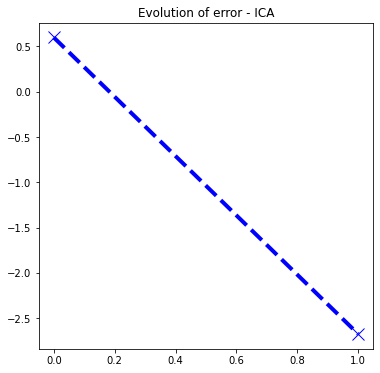

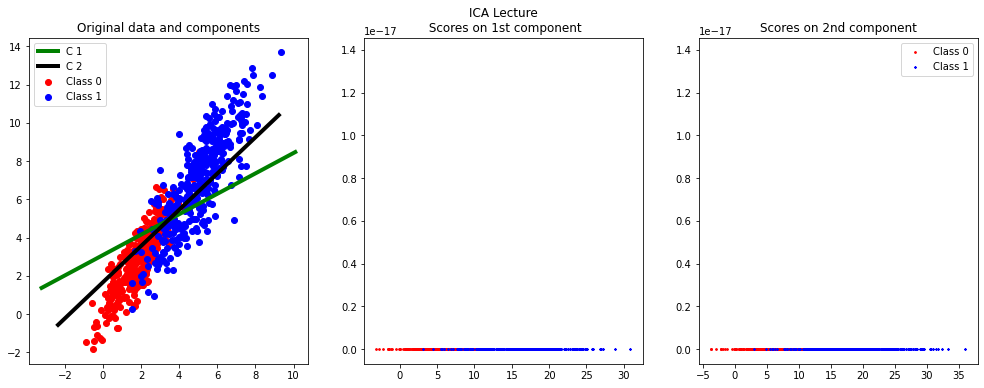

In [ ]:
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

SicaLec,WicaLec = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X=X, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')

With a different perspective, we could also use K-means. As before, we will use it on X and we will check whether it can well separate the two classes. 


**Question:** Does it work well in all scenarios ? Why ?


**Answer:** No, it only works well on scenario 1, where the mean of each distribution are far away from one another. Since the distributions 2,3 variance relative to one another isn't greater to the variance among the distribution themselves, the method doesn't work well. Distribution 4 have the same centroid for both circles, It would be impossible for k means to work here...

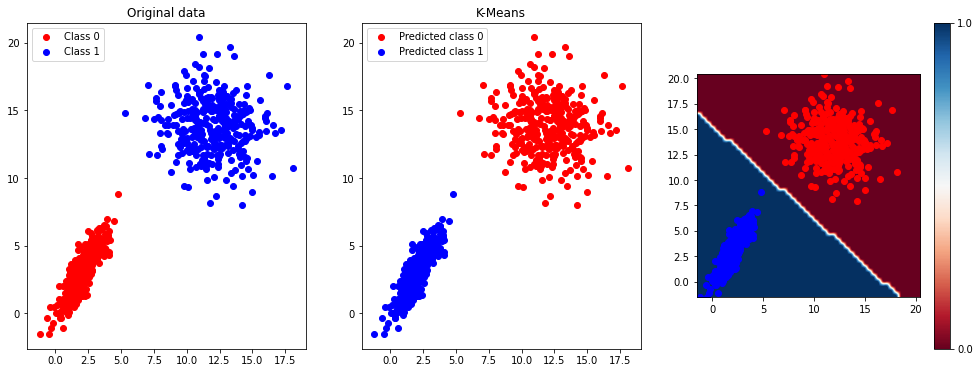

In [ ]:
## K-means
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

kmeans=KMeans(n_clusters=2)
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

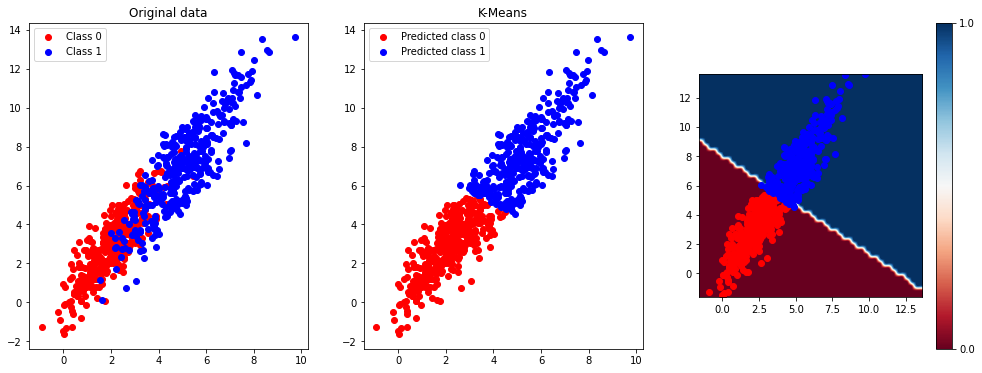

In [ ]:
X0,X1,y = generate_scenario(scenario=2, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

kmeans=KMeans(n_clusters=2)
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

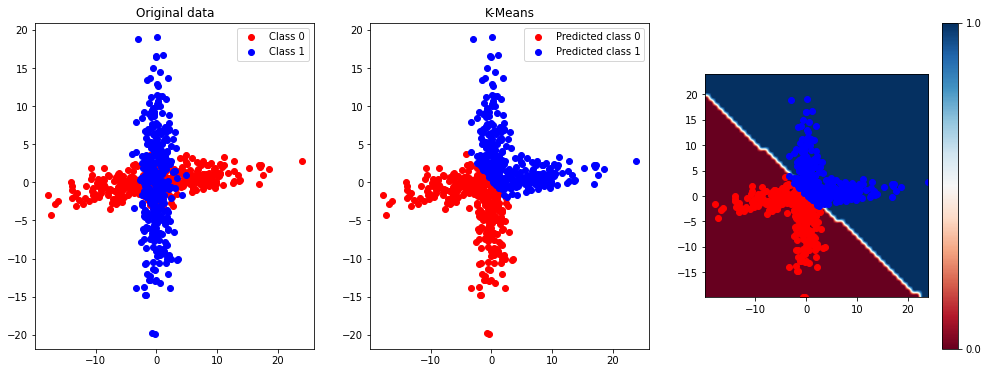

In [ ]:
X0,X1,y = generate_scenario(scenario=3, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

kmeans=KMeans(n_clusters=2)
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

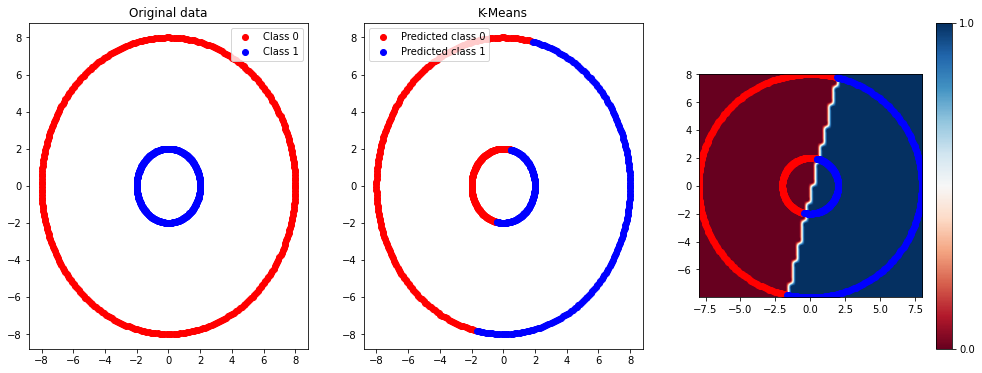

In [ ]:
X0,X1,y = generate_scenario(scenario=4, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

kmeans=KMeans(n_clusters=2)
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()